<a href="https://colab.research.google.com/github/kirtiman24/Image-Captioning/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import pandas as pd
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_path = "/content/drive/My Drive/Image Data/Images"

import tensorflow as tf

def loadImages(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    return image_files

In [ ]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
train_captions_path="/content/drive/My Drive/Flickr8k.token.txt"
captions=readTextFile(train_captions_path)
captions=captions.split('\n')[:-1]

In [ ]:
print(captions[0].split('\t'))

['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']


In [ ]:
first,second=captions[0].split('\t')

In [ ]:
print(first.split('.')[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
descriptions={}
for x in captions:
  first,second=x.split('\t')
  img_name=first.split('.')[0]
  if descriptions.get(img_name) is None:
    descriptions[img_name]=list()

  descriptions[img_name].append(second)

    

In [ ]:
descriptions["1012212859_01547e3f17"]

['A dog shakes its head near the shore , a red ball next to it .',
 'A white dog shakes on the edge of a beach with an orange ball .',
 'Dog with orange ball at feet , stands on shore shaking off water',
 'White dog playing with a red ball on the shore near the water .',
 'White dog with brown ears standing near water with head turned to one side .']

**Data Cleaning**

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [ ]:
clean_text("This. is s hds#AADM")

'this is hds aadm'

In [ ]:
for key,caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i]=clean_text(caption_list[i])

In [ ]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

**Vocabulary**

In [ ]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
# Vocabulary
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))


Vocab Size : 8424


In [ ]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 373837


In [ ]:

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt))


8424


In [ ]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]


In [ ]:
print(len(total_words))

1845


**Preparing training and testing data**

In [ ]:
train_file_data = readTextFile("/content/drive/My Drive/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/My Drive/Flickr_8k.testImages.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train[:10]


['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154']

In [ ]:
train_descriptions={}
for img_id in train:
  train_descriptions[img_id]=[]
  for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

**Image Feature Extraction**

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()


102858752/102853048 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
!mkdir saved

In [ ]:
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Total Time Taken : 635.1604964733124


In [ ]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

**Data Prepprocessing for the captions**

In [ ]:
print(len(total_words))

1845


In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
print(word_to_idx["is"])
print(idx_to_word[4])

4
is


In [ ]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [ ]:
train_descriptions["1007129816_e794419615"]

['startseq man in an orange hat starring at something endseq',
 'startseq man wears an orange hat and glasses endseq',
 'startseq man with gauges and glasses is wearing blitz hat endseq',
 'startseq man with glasses is wearing beer can crocheted hat endseq',
 'startseq the man with pierced ears is wearing glasses and an orange hat endseq']

In [ ]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


**Data Loader (Generator)**

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0


In [ ]:
f = open("/content/drive/My Drive/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [ ]:
f.close()

In [ ]:
embedding_index['sequence']

array([ 0.96724 ,  0.36258 , -0.10351 ,  0.7062  ,  0.80155 ,  0.9357  ,
        0.89186 , -0.31736 ,  0.33319 ,  0.36154 , -0.069239, -0.16891 ,
       -0.38503 ,  0.78906 ,  0.44389 , -0.23609 ,  0.072883, -0.89942 ,
       -0.75661 , -0.31623 , -0.071976, -0.94792 ,  0.64148 ,  0.57177 ,
        0.68477 ,  0.2077  , -1.1461  , -0.079607,  0.36625 , -0.51025 ,
        2.5446  , -0.96487 , -0.018315, -0.75748 ,  0.84783 ,  0.3523  ,
        0.65783 , -0.34893 , -0.80028 ,  0.36755 , -0.2085  , -0.089226,
       -0.75459 , -0.099513, -0.69164 ,  0.022976,  2.2213  ,  0.19255 ,
        0.092026,  0.11685 ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

**Model Architecture**

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:




model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

**Model Training**

In [ ]:
len(train_descriptions)

6000

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)/batch_size

In [ ]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
model = load_model('/content/drive/My Drive/model_9.h5')


**Getting Predictions**

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Word with max probability is predicted - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [ ]:
print(encoding_test.items)

<built-in method items of dict object at 0x7f1cb1f0dfc0>


**Sample Predictions**

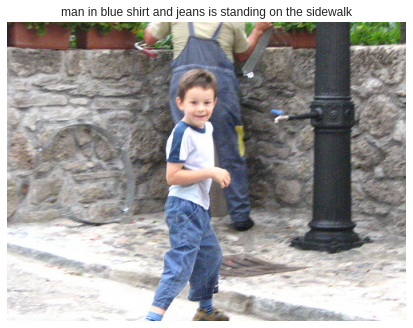

In [ ]:
photo_2048 = encode_image("/content/drive/My Drive/Image Data/Images/1015118661_980735411b.jpg").reshape((1,2048))
i = plt.imread("/content/drive/My Drive/Image Data/Images/1015118661_980735411b.jpg")
caption = predict_caption(photo_2048)
plt.title(caption)
plt.imshow(i)
plt.axis("off")
plt.show()


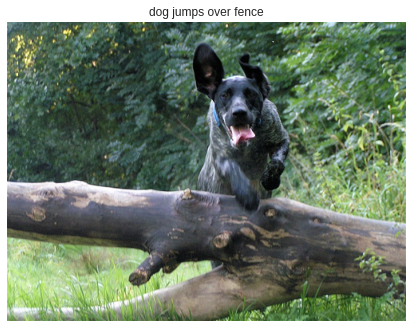

In [ ]:
photo_2048 = encode_image("/content/drive/My Drive/Image Data/Images/1015584366_dfcec3c85a.jpg").reshape((1,2048))
i = plt.imread("/content/drive/My Drive/Image Data/Images/1015584366_dfcec3c85a.jpg")
caption = predict_caption(photo_2048)
plt.title(caption)
plt.imshow(i)
plt.axis("off")
plt.show()

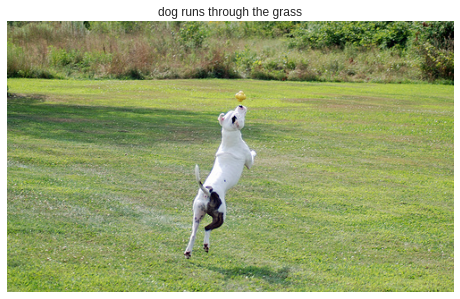

In [ ]:
photo_2048 = encode_image("/content/drive/My Drive/Image Data/Images/1020651753_06077ec457.jpg").reshape((1,2048))
i = plt.imread("/content/drive/My Drive/Image Data/Images/1020651753_06077ec457.jpg")
caption = predict_caption(photo_2048)
plt.title(caption)
plt.imshow(i)
plt.axis("off")
plt.show()

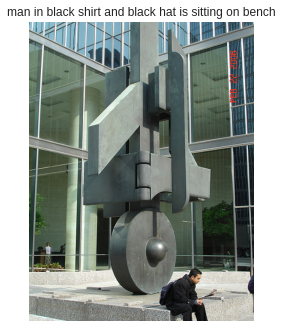

In [ ]:
photo_2048 = encode_image("/content/drive/My Drive/Image Data/Images/103195344_5d2dc613a3.jpg").reshape((1,2048))
i = plt.imread("/content/drive/My Drive/Image Data/Images/103195344_5d2dc613a3.jpg")
caption = predict_caption(photo_2048)
plt.title(caption)
plt.imshow(i)
plt.axis("off")
plt.show()